In [1]:
import numpy as np
from scipy.stats import t

In [2]:
from sklearn.datasets import fetch_openml

X, y = fetch_openml('mnist_784', version=1, return_X_y=True)#, parser='auto')
X = X.values

X = X / 255. #normalization to [0,1]

y = X

print(X.shape)
print(y.shape)

(70000, 784)
(70000, 784)


In [3]:
from sklearn.model_selection import train_test_split


X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=10000, random_state=123)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_temp, y_temp, test_size=5000, random_state=123)

del X_temp, y_temp, X, y

In [4]:
##########################
### t_prior_VAE
##########################
def sigmoid(z):                                        
    return 1. / (1. + np.exp(-z))

def relu(z): #relu
    return np.maximum(0, z)

def relu_deriv(z):
    return np.where(z > 0, 1, 0)


class t_prior_VAE:

    def __init__(self, input_size, hidden_size1, hidden_size2, latent_size, df, random_seed=123): 
        
        rng = np.random.RandomState(random_seed)
        self.df = df # degree of freedom of prior t-distribution
        
        # encoder weights
        self.W_e1 = rng.normal(
            loc=0.0, scale=0.1, size=(hidden_size1, input_size))
        self.b_e1 = np.zeros((1, hidden_size1))
        
        self.W_e2 = rng.normal(
            loc=0.0, scale=0.1, size=(hidden_size2, hidden_size1))
        self.b_e2 = np.zeros((1, hidden_size2))
        
        self.W_e3 = rng.normal(
            loc=0.0, scale=0.1, size=(latent_size * 2, hidden_size2))
        self.b_e3 = np.zeros((1, latent_size * 2))
        
        
        # decoder weights
        self.W_d1 = rng.normal(
            loc=0.0, scale=0.1, size=(hidden_size2, latent_size))
        self.b_d1 = np.zeros((1, hidden_size2))
        
        self.W_d2 = rng.normal(
            loc=0.0, scale=0.1, size=(hidden_size1, hidden_size2))
        self.b_d2 = np.zeros((1, hidden_size1))
        
        self.W_d3 = rng.normal(
            loc=0.0, scale=0.1, size=(input_size, hidden_size1))
        self.b_d3 = np.zeros((1, input_size))

    def encoder(self, x):
        z_e1 = x @ self.W_e1.T + self.b_e1
        a_e1 = relu(z_e1) # activation

        z_e2 = a_e1 @ self.W_e2.T + self.b_e2
        a_e2 = relu(z_e2) # activation

        mu_logvar = a_e2 @ self.W_e3.T + self.b_e3 # linear
        mu, logvar = np.split(mu_logvar, 2, axis=1)
        
        return z_e1, a_e1, z_e2, a_e2, mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = np.exp(0.5 * logvar)
        #eps = np.random.normal(size=mu.shape)
        eps = t.rvs(df=self.df, size=mu.shape) # student's t iid matrix with degree of freedom v+n
        
        latent = mu + eps * std
        
        return latent, eps

    def decoder(self, latent):
        z_d1 = latent @ self.W_d1.T + self.b_d1
        a_d1 = relu(z_d1) # activation
        
        z_d2 = a_d1 @ self.W_d2.T + self.b_d2
        a_d2 = relu(z_d2) # activation

        z_d3 = a_d2 @ self.W_d3.T + self.b_d3
        recon_x = sigmoid(z_d3) # sigmoid
    
        return z_d1, a_d1, z_d2, a_d2, recon_x

    def forward(self, x):
        z_e1, a_e1, z_e2, a_e2, mu, logvar = self.encoder(x)
        latent, eps = self.reparameterize(mu, logvar)
        z_d1, a_d1, z_d2, a_d2, recon_x = self.decoder(latent)
        
        return z_e1, a_e1, z_e2, a_e2, mu, logvar, latent, z_d1, a_d1, z_d2, a_d2, recon_x, eps
        
    
    def backward(self, x, z_e1, a_e1, z_e2, a_e2, mu, logvar, latent, z_d1, a_d1, z_d2, a_d2, recon_x, y, eps):

        # decoder backprop
        dL__dz_d3 = (recon_x - y) / y.shape[0] # only by REC
        
        dL__dw_d3 = dL__dz_d3.T @ a_d2
        dL__db_d3 = np.sum(dL__dz_d3, axis=0)

        
        dL__da_d2 = dL__dz_d3 @ self.W_d3
        dL__dz_d2 = dL__da_d2 * relu_deriv(z_d2) # activation derivative

        dL__dw_d2 = dL__dz_d2.T @ a_d1
        dL__db_d2 = np.sum(dL__dz_d2, axis=0)

        
        dL__da_d1 = dL__dz_d2 @ self.W_d2
        dL__dz_d1 = dL__da_d1 * relu_deriv(z_d1) # activation derivative

        dL__dw_d1 = dL__dz_d1.T @ latent
        dL__db_d1 = np.sum(dL__dz_d1, axis=0)

        
        # reparameterize backprop
        dL__dlatent = dL__dz_d1 @ self.W_d1
        
        dL__dmu = dL__dlatent * 1 # gradient by RCE term
        dL__dstd = dL__dlatent * eps # gradient by RCE term
        std = np.exp(0.5 * logvar)

        dL__dmu += ((self.df + 1) * latent / (self.df + np.power(latent, 2)) * 1) / y.shape[0] # gradient by KL term
        dL__dstd += (-1 / std + (self.df + 1) * latent / (self.df + np.power(latent, 2)) * eps ) / y.shape[0] # gradient by KL term
        
        dL__dlogvar = dL__dstd * 0.5 * std

        
        # encoder backprop
        dL__dz_e3 = np.hstack((dL__dmu, dL__dlogvar))
        
        dL__dw_e3 = dL__dz_e3.T @ a_e2
        dL__db_e3 = np.sum(dL__dz_e3, axis=0)

        
        dL__da_e2 = dL__dz_e3 @ self.W_e3
        dL__dz_e2 = dL__da_e2 * relu_deriv(z_e2) # activation derivative
        
        dL__dw_e2 = dL__dz_e2.T @ a_e1
        dL__db_e2 = np.sum(dL__dz_e2, axis=0)


        dL__da_e1 = dL__dz_e2 @ self.W_e2
        dL__dz_e1 = dL__da_e1 * relu_deriv(z_e1) # activation derivative
        
        dL__dw_e1 = dL__dz_e1.T @ x
        dL__db_e1 = np.sum(dL__dz_e1, axis=0)
        
        return dL__dw_d3, dL__db_d3, dL__dw_d2, dL__db_d2, dL__dw_d1, dL__db_d1, \
               dL__dw_e3, dL__db_e3, dL__dw_e2, dL__db_e2, dL__dw_e1, dL__db_e1

In [5]:
def minibatch_generator(X, y, minibatch_size): ##stable
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)

    for start_idx in range(0, indices.shape[0] - minibatch_size 
                           + 1, minibatch_size):
        batch_idx = indices[start_idx:start_idx + minibatch_size]
        
        yield X[batch_idx], y[batch_idx]
    
def compute_loss_mse(nnet, X, y, minibatch_size):
    loss_=0
    mse_=0
    minibatch_gen = minibatch_generator(X, y, minibatch_size)
        
    for i, (X_mini, y_mini) in enumerate(minibatch_gen):

        z_e1, a_e1, z_e2, a_e2, mu, logvar, latent, z_d1, a_d1, z_d2, a_d2, recon_x, eps = nnet.forward(X_mini)

        RCE = -np.sum(y_mini * np.log(recon_x) + (1 - y_mini) * np.log(1 - recon_x)) / minibatch_size # binary cross entropy loss       
        KLD = np.sum(-0.5 * logvar + 0.5 * (nnet.df + 1) * (np.log(1 + 1 / nnet.df * np.power(latent, 2)) - np.log(1 + 1 / nnet.df * np.power(((latent - mu) / np.exp(0.5 * logvar)), 2)))) / minibatch_size # KL divergence Loss
        
        loss = RCE + KLD
        loss_ += loss
        
        mse = np.mean((recon_x - y_mini) ** 2)
        mse_ += mse

    loss_ /= (i+1)
    mse_ /= (i+1)
    return loss_, mse_

def train(model, X_train, y_train, X_valid, y_valid, num_epochs, minibatch_size, learning_rate):

    epoch_train_loss = []
    epoch_valid_loss = []
    
    for e in range(num_epochs):

        # iterate over minibatches
        minibatch_gen = minibatch_generator(
            X_train, y_train, minibatch_size)

        for X_train_mini, y_train_mini in minibatch_gen:
            
            #### Compute outputs ####
            z_e1, a_e1, z_e2, a_e2, mu, logvar, latent, z_d1, a_d1, z_d2, a_d2, recon_x, eps = model.forward(X_train_mini)

            #### Compute gradients ####
            
            dL__dw_d3, dL__db_d3, dL__dw_d2, dL__db_d2, dL__dw_d1, dL__db_d1, dL__dw_e3, dL__db_e3, dL__dw_e2, dL__db_e2, dL__dw_e1, dL__db_e1 = \
                model.backward(X_train_mini, z_e1, a_e1, z_e2, a_e2, mu, logvar, latent, z_d1, a_d1, z_d2, a_d2, recon_x, y_train_mini, eps)

            #### Update weights ####
            model.W_d1 -= learning_rate * dL__dw_d1
            model.b_d1 -= learning_rate * dL__db_d1
            model.W_d2 -= learning_rate * dL__dw_d2
            model.b_d2 -= learning_rate * dL__db_d2
            model.W_d3 -= learning_rate * dL__dw_d3
            model.b_d3 -= learning_rate * dL__db_d3
            
            model.W_e1 -= learning_rate * dL__dw_e1
            model.b_e1 -= learning_rate * dL__db_e1
            model.W_e2 -= learning_rate * dL__dw_e2
            model.b_e2 -= learning_rate * dL__db_e2
            model.W_e3 -= learning_rate * dL__dw_e3
            model.b_e3 -= learning_rate * dL__db_e3
        
        #### Epoch Logging ####        
        train_loss, train_mse = compute_loss_mse(model, X_train, y_train, minibatch_size)
        valid_loss, valid_mse = compute_loss_mse(model, X_valid, y_valid, minibatch_size)

        epoch_train_loss.append(train_loss)
        epoch_valid_loss.append(valid_loss)
        
        print(f'Epoch: {e+1:03d}/{num_epochs:03d} '
              f'| Train loss: {train_loss:.5f} '
              f'| Valid loss: {valid_loss:.5f} '
              f'| Train mse: {train_mse:.5f} '
              f'| Valid mse: {valid_mse:.5f} ')

    return epoch_train_loss, epoch_valid_loss


In [6]:
epochs=300
batch_size=500
lr=0.005
df=21

In [7]:
model=t_prior_VAE(28*28, 400, 128, 10, df=df)
epoch_train_loss, epoch_valid_loss = train(model, X_train, y_train, X_valid, y_valid, num_epochs=epochs, minibatch_size=batch_size, learning_rate=lr)

Epoch: 001/300 | Train loss: 204.81531 | Valid loss: 205.30943 | Train mse: 0.06410 | Valid mse: 0.06425 
Epoch: 002/300 | Train loss: 195.46111 | Valid loss: 195.97445 | Train mse: 0.05985 | Valid mse: 0.06005 
Epoch: 003/300 | Train loss: 179.65567 | Valid loss: 180.03347 | Train mse: 0.05134 | Valid mse: 0.05140 
Epoch: 004/300 | Train loss: 170.19146 | Valid loss: 170.27706 | Train mse: 0.04703 | Valid mse: 0.04695 
Epoch: 005/300 | Train loss: 165.54536 | Valid loss: 165.75570 | Train mse: 0.04506 | Valid mse: 0.04505 
Epoch: 006/300 | Train loss: 158.94963 | Valid loss: 159.20763 | Train mse: 0.04213 | Valid mse: 0.04215 
Epoch: 007/300 | Train loss: 155.58047 | Valid loss: 155.83063 | Train mse: 0.04022 | Valid mse: 0.04025 
Epoch: 008/300 | Train loss: 153.46054 | Valid loss: 153.69062 | Train mse: 0.03925 | Valid mse: 0.03925 
Epoch: 009/300 | Train loss: 150.71908 | Valid loss: 150.94088 | Train mse: 0.03785 | Valid mse: 0.03783 
Epoch: 010/300 | Train loss: 149.15060 | Valid

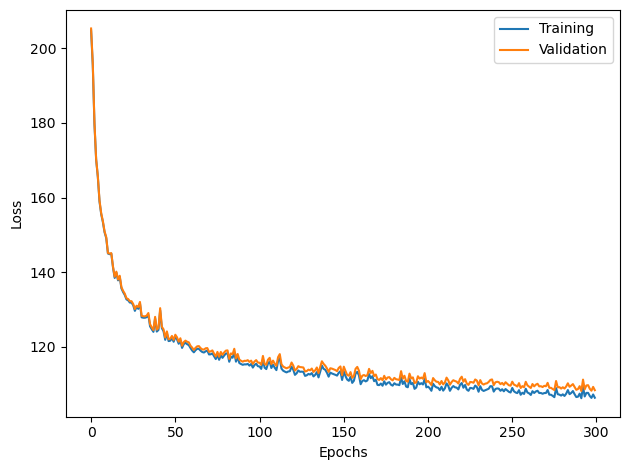

In [8]:
import matplotlib.pyplot as plt

plt.plot(range(len(epoch_train_loss)), epoch_train_loss,
         label='Training')
plt.plot(range(len(epoch_valid_loss)), epoch_valid_loss,
         label='Validation')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

In [9]:
import pickle

with open('t_prior_VAE_MNIST.p', 'wb') as file:
    pickle.dump(model, file)
    pickle.dump(epoch_train_loss, file)
    pickle.dump(epoch_valid_loss, file)

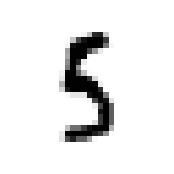

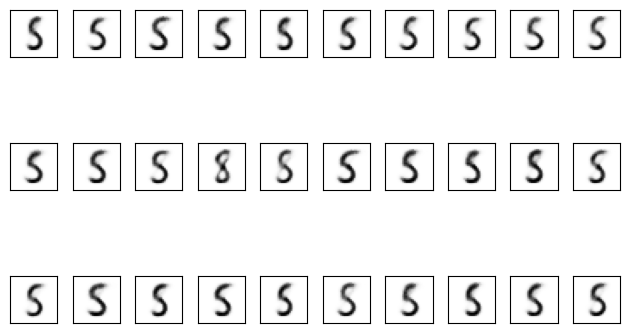

In [10]:
n=np.random.randint(0,10000,1)
n=3001
plt.figure(figsize=(2, 2)) # original data
plt.imshow(X_test[n,:].reshape(28,28),cmap='Greys')
plt.axis('off')
plt.show() 

fig, ax = plt.subplots(nrows=3, ncols=10, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(30):
    _, _, _, _, _, _, _, _, _, _, _, pred, _ = model.forward(X_test[n,:])
    img = pred.reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

In [11]:
n

3001